In [1]:
%matplotlib notebook

In [2]:
from pyroteus import *
import matplotlib
import matplotlib.pyplot as plt

In [3]:
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 18

In [4]:
PETSc.Sys.popErrorHandler()

In [5]:
p = 1
family = "CG"
norm_order = 1
resolutions = [8, 16, 32, 64, 128, 256]
powers = [0, 1, 2, 3, 4]
targets = 25*4**np.array(powers)

In [6]:
def kernel(V):
    x, y = SpatialCoordinate(V.mesh())
    return (0.5*pi + atan(80*(x - 0.5)))*x*y*(x-1)*(y-1)

In [7]:
def source(V):
    x, y = SpatialCoordinate(V.mesh())
    return 2*pi*pi*sin(pi*x)*sin(pi*y)

In [8]:
sp = {
    "ksp_type": "cg",
    "pc_type": "none",
}
sp_mass_inv = {
    "mat_type": "matfree",
    "ksp_type": "preonly",
    "pc_type": "python",
    "pc_python_type": "firedrake.MassInvPC",
}
sp_ibp = {
    "ksp_type": "gmres",
    "ksp_gmres_restart": 20,
    "ksp_rtol": 1.0e-05,
    "pc_type": "sor",
}
sp_l2_proj = {
    'mat_type': 'aij',
    'ksp_type': 'gmres',
    'pc_type': 'fieldsplit',
    'pc_fieldsplit_type': 'schur',
    'pc_fieldsplit_0_fields': '1',
    'pc_fieldsplit_1_fields': '0',
    'pc_fieldsplit_schur_precondition': 'selfp',
    'fieldsplit_0_pc_type': 'ilu',
    'fieldsplit_0_ksp_type': 'preonly',
    'fieldsplit_1_ksp_type': 'preonly',
    'fieldsplit_1_pc_type': 'gamg',
    'ksp_max_it': 20,
}

In [9]:
def solve_forward(V, solver_parameters=sp):
    mesh = V.mesh()
    u, v = TrialFunction(V), TestFunction(V)
    f = source(V)
    
    a = inner(grad(u), grad(v))*dx
    L = f*v*dx
    
    uh = Function(V)
    bc = DirichletBC(V, 0, 'on_boundary')
    solve(a == L, uh, bcs=bc, solver_parameters=solver_parameters)
    return uh

In [10]:
def solve_adjoint(V):
    mesh = V.mesh()
    u, v = TrialFunction(V), TestFunction(V)
    f = kernel(V)
    
    a = inner(grad(u), grad(v))*dx
    L = inner(grad(f), grad(v))*dx
    
    uh = Function(V)
    bc = DirichletBC(V, 0, 'on_boundary')
    solve(a == L, uh, bcs=bc, solver_parameters=sp)
    return uh

In [11]:
def exact_solution(V):
    x, y = SpatialCoordinate(V.mesh())
    return sin(pi*x)*sin(pi*y)

In [12]:
def qoi(u, V=None):
    V = V or u.function_space()
    return assemble(inner(grad(u), grad(kernel(V)))*dx(domain=V.mesh()))

In [13]:
qoi_exact = 0.51602455

In [14]:
dofs = []
elements = []
uniform = []
print("DoFs    QoI error")
for N in resolutions:
    mesh = UnitSquareMesh(N, N)
    Vc = FunctionSpace(mesh, family, p)
    uc = solve_forward(Vc)
    
    dof = Vc.dof_count
    Ju = qoi(uc, Vc)
    Je = abs(qoi_exact - Ju)/qoi_exact
    
    print(f"{dof:6d}  {Je:.4e}")
    dofs.append(dof)
    uniform.append(Je)

DoFs    QoI error
    81  3.7932e-02
   289  9.5992e-03
  1089  2.4071e-03
  4225  6.0224e-04
 16641  1.5059e-04
 66049  3.7647e-05


<IPython.core.display.Javascript object>


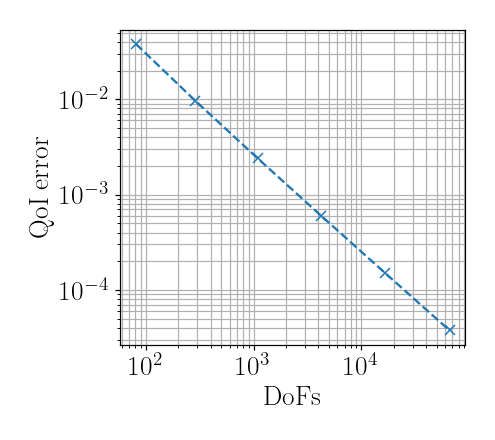

In [15]:
fig, axes = plt.subplots(figsize=(4.5, 4))
axes.loglog(dofs, uniform, '--x')
axes.set_xlabel("DoFs")
axes.set_ylabel("QoI error")
axes.grid(True, which='both')
plt.tight_layout()

In [16]:
def recover_gradient(u, V):
    test, trial = TestFunction(V), TrialFunction(V)
    a = inner(test, trial)*dx
    L = u*inner(test, FacetNormal(V.mesh()))*ds - div(test)*u*dx
    g = Function(V)
    solve(a == L, g, solver_parameters=sp_ibp)
    return g

In [17]:
def recover_hessian(u, W):
    n = FacetNormal(W.mesh())
    V = VectorFunctionSpace(W.mesh(), "CG", 1)
    S = V*W
    v, tau = TestFunctions(S)
    g, sigma = TrialFunctions(S)
    a = inner(v, g)*dx + inner(tau, sigma)*dx + inner(div(tau), g)*dx - dot(g, dot(tau, n))*ds
    L = u*dot(v, n)*ds - div(v)*u*dx
    sol = Function(S)
    solve(a == L, sol, solver_parameters=sp_l2_proj)
    return sol.split()[1]

In [18]:
def forward_metric(u, u_adj):
    mesh = u.function_space().mesh()
    V = VectorFunctionSpace(mesh, "CG", 1)
    W = TensorFunctionSpace(mesh, "CG", 1)
    grad_u = recover_gradient(u, V)
    grad_u_adj = recover_gradient(u_adj, V)
    
    M1 = hessian_metric(recover_hessian(grad_u[0], W))
    M1.interpolate(M1*abs(grad_u_adj[0]))
    M1 = hessian_metric(M1)
    space_normalise(M1, target, norm_order)
    
    M2 = hessian_metric(recover_hessian(grad_u[1], W))
    M2.interpolate(M2*abs(grad_u_adj[1]))
    M2 = hessian_metric(M2)
    space_normalise(M2, target, norm_order)
    
    Mf = hessian_metric(recover_hessian(source(V), W))
    Mf.interpolate(Mf*abs(u_adj))
    Mf = hessian_metric(Mf)
    space_normalise(Mf, target, norm_order)
    
    return metric_average(M1, M2, Mf)

In [19]:
def adjoint_metric(u, u_adj):
    mesh = u.function_space().mesh()
    V = VectorFunctionSpace(mesh, "CG", 1)
    W = TensorFunctionSpace(mesh, "CG", 1)
    grad_u = recover_gradient(u, V)
    grad_u_adj = recover_gradient(u_adj, V)
    
    M1 = hessian_metric(recover_hessian(grad_u_adj[0], W))
    M1.interpolate(M1*abs(grad_u[0]))
    M1 = hessian_metric(M1)
    space_normalise(M1, target, norm_order)
    
    M2 = hessian_metric(recover_hessian(grad_u_adj[1], W))
    M2.interpolate(M2*abs(grad_u[1]))
    M2 = hessian_metric(M2)
    space_normalise(M2, target, norm_order)
    
    Mf = hessian_metric(recover_hessian(kernel(V), W))
    Mf.interpolate(Mf*abs(u))
    Mf = hessian_metric(Mf)
    space_normalise(Mf, target, norm_order)
    
    return metric_average(M1, M2, Mf)

In [20]:
def averaged_metric(u, u_adj):
    return metric_average(forward_metric(u, u_adj), adjoint_metric(u, u_adj))

In [21]:
def check_converged(Je, cells, old, rtol=0.01):
    if old == {}:
        return False
    elif (abs(Je - old['Je']) < rtol*abs(old['Je'])
          and abs(cells - old['cells']) < rtol*abs(old['cells'])):
        return True
    else:
        return False

In [22]:
errors_fwd, errors_adj, errors_avg = [], [], []
dofs_fwd, dofs_adj, dofs_avg = [], [], []
N = 10
maxiter = 35
to_plot = []
msg = "Target   Forward      Adjoint      Average\n"
for j, target in enumerate(targets):
    
    mesh_fwd = UnitSquareMesh(N, N)
    old = {}
    for i in range(maxiter):
        V = FunctionSpace(mesh_fwd, family, p)
        u = solve_forward(V)
        Je = qoi(u, V)
        if i == maxiter-1:
            break
        u_adj = solve_adjoint(V)
        M = forward_metric(u, u_adj)
        mesh_fwd = adapt(mesh_fwd, M)
        cells = mesh_fwd.num_cells()
        if check_converged(Je, cells, old):
            print(f"{j}: Forward converged in {i+1} iterations")
            break
        old['Je'] = Je
        old['cells'] = cells
    errors_fwd.append(abs(qoi_exact - Je)/qoi_exact)
    dofs_fwd.append(V.dof_count)
    
    mesh_adj = UnitSquareMesh(N, N)
    old = {}
    for i in range(maxiter):
        V = FunctionSpace(mesh_adj, family, p)
        u = solve_forward(V)
        Je = qoi(u, V)
        if i == maxiter-1:
            break
        u_adj = solve_adjoint(V)
        M = adjoint_metric(u, u_adj)
        mesh_adj = adapt(mesh_adj, M)
        cells = mesh_adj.num_cells()
        if check_converged(Je, cells, old):
            print(f"{j}: Adjoint converged in {i+1} iterations")
            break
        old['Je'] = Je
        old['cells'] = cells
    errors_adj.append(abs(qoi_exact - Je)/qoi_exact)
    dofs_adj.append(V.dof_count)
    
    mesh_avg = UnitSquareMesh(N, N)
    old = {}
    for i in range(maxiter):
        V = FunctionSpace(mesh_avg, family, p)
        u = solve_forward(V)
        Je = qoi(u, V)
        if i == maxiter-1:
            break
        u_adj = solve_adjoint(V)
        M = averaged_metric(u, u_adj)
        mesh_avg = adapt(mesh_avg, M)
        cells = mesh_avg.num_cells()
        if check_converged(Je, cells, old):
            print(f"{j}: Average converged in {i+1} iterations")
            break
        old['Je'] = Je
        old['cells'] = cells
    errors_avg.append(abs(qoi_exact - Je)/qoi_exact)
    dofs_avg.append(V.dof_count)
    
    msg += f"{target:6.0f}   {errors_fwd[-1]:.4e}   {errors_adj[-1]:.4e}   {errors_avg[-1]:.4e}\n"
    if j == 2:
        to_plot = [mesh_fwd, mesh_adj, mesh_avg]
print(msg)

0: Forward converged in 7 iterations
0: Adjoint converged in 17 iterations
0: Average converged in 7 iterations
1: Forward converged in 6 iterations
1: Adjoint converged in 4 iterations
1: Average converged in 9 iterations
2: Forward converged in 6 iterations
2: Adjoint converged in 3 iterations
2: Average converged in 5 iterations
3: Forward converged in 4 iterations
3: Adjoint converged in 3 iterations
3: Average converged in 4 iterations
4: Forward converged in 4 iterations
4: Adjoint converged in 3 iterations
4: Average converged in 4 iterations
Target   Forward      Adjoint      Average
    25   4.3931e-02   6.5910e-02   4.1193e-02
   100   6.3525e-03   1.7532e-02   1.1787e-02
   400   9.9434e-04   3.8891e-03   2.7811e-03
  1600   3.3099e-04   1.0641e-03   6.5682e-04
  6400   8.2754e-05   2.6132e-04   1.6372e-04



<IPython.core.display.Javascript object>


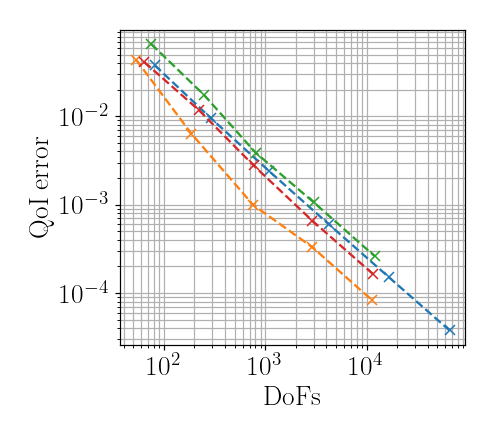

<IPython.core.display.Javascript object>


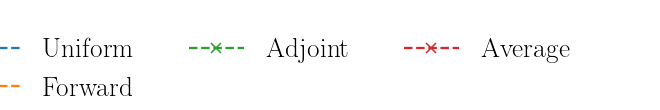

In [23]:
fig, axes = plt.subplots(figsize=(4.5, 4))
axes.loglog(dofs, uniform, '--x', label='Uniform')
axes.loglog(dofs_fwd, errors_fwd, '--x', label='Forward')
axes.loglog(dofs_adj, errors_adj, '--x', label='Adjoint')
axes.loglog(dofs_avg, errors_avg, '--x', label='Average')
axes.set_xlabel("DoFs")
axes.set_ylabel("QoI error")
axes.grid(True, which='both')
plt.tight_layout()
plt.savefig('qoi_convergence_a_priori2.pdf')

fig2, axes2 = plt.subplots(figsize=(6, 1))
lines, labels = axes.get_legend_handles_labels()
legend = axes2.legend(lines, labels, fontsize=18, frameon=False, ncol=3)
fig2.canvas.draw()
axes2.set_axis_off()
bbox = legend.get_window_extent().transformed(fig2.dpi_scale_trans.inverted())

<IPython.core.display.Javascript object>


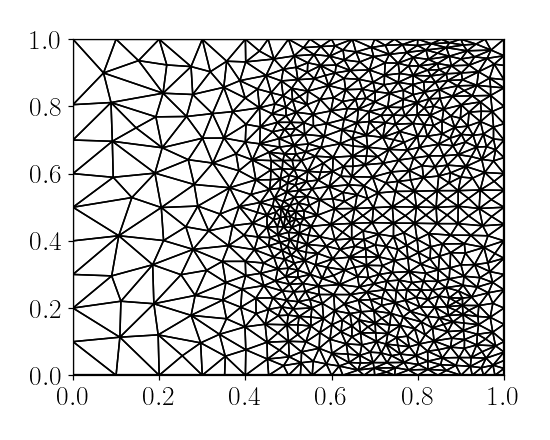

<IPython.core.display.Javascript object>


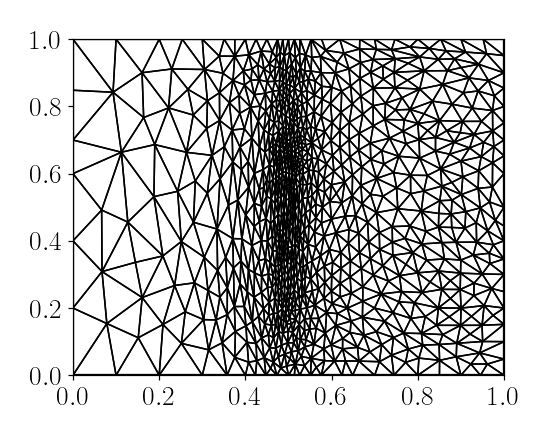

<IPython.core.display.Javascript object>


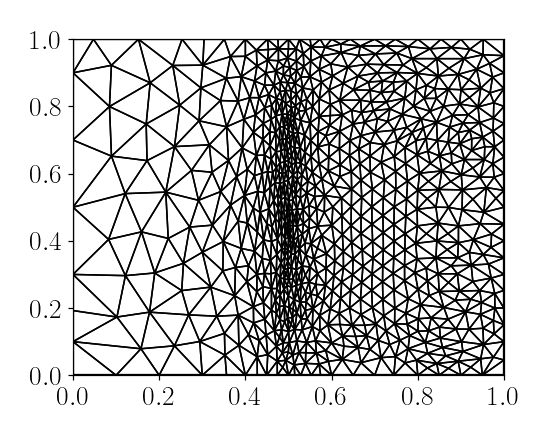

In [24]:
fig, axes = plt.subplots(figsize=(5, 4))
triplot(to_plot[0], axes=axes, boundary_kw={'edgecolor': 'k'})
axes.set_xlim([0, 1])
axes.set_ylim([0, 1])
plt.tight_layout()
plt.savefig('forward_mesh2.jpg')

fig, axes = plt.subplots(figsize=(5, 4))
triplot(to_plot[1], axes=axes, boundary_kw={'edgecolor': 'k'})
axes.set_xlim([0, 1])
axes.set_ylim([0, 1])
plt.tight_layout()
plt.savefig('adjoint_mesh2.jpg')

fig, axes = plt.subplots(figsize=(5, 4))
triplot(to_plot[2], axes=axes, boundary_kw={'edgecolor': 'k'})
axes.set_xlim([0, 1])
axes.set_ylim([0, 1])
plt.tight_layout()
plt.savefig('average_mesh2.jpg')